# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

SELF_TEST = True

In [2]:
# !conda install sentence-transformers -y

In [3]:
# jupyter nbextension enable --py widgetsnbextension
# !conda install ipywidgets widgetsnbextension -y


In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-11-10 20:50:46,533 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [5]:
nb_dir = os.path.split(os.getcwd())[0]

if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v3.0.0
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

In [6]:
from sentence_transformers import SentenceTransformer
 
sentence_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
sentence_model.max_seq_length = 512
 

### Prepare workdir

In [7]:
from pathlib import Path

from analyser.hyperparams import work_dir  

# _work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
# work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

# if not os.path.isdir(work_dir):
#     os.mkdir(work_dir)

# analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [8]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection
from pymongo import ASCENDING

from analyser.hyperparams import models_path

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


# Read patterns CSV

In [9]:
csv_path = Path(models_path)/'insides_keyphrases.tsv'
csv_path.is_file()

True

In [10]:
insides_keyphrases_df = pd.read_csv(csv_path, encoding_errors="ignore" , sep='\t')
insides_keyphrases_df

,Ключевые выражения,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,В предмете договора (в перечне услуг),В правах и обязанностях,В Приложении,NaN,NaN
1,Присвоение Кредитного рейтинга,Предоставить необходимую для проведения Рейтин...,NaN,NaN,NaN
2,Прогноз по Кредитному рейтингу,"Изменение структуры собственности, реорганизац...",NaN,NaN,NaN
3,Поддержание Кредитного рейтинга Заказчика,дополнительную информацию о финансово-хозяйств...,NaN,NaN,NaN
4,NaN,"изменение структуры собственности, реорганизац...",NaN,NaN,NaN
...,...,...,...,...,...
122,Подготовка отчета по результатам мониторинга с...,NaN,NaN,NaN,NaN
123,Подготовка отчета по результатам мониторинга в...,NaN,NaN,NaN,NaN
124,Подготовка отчета по результатам мониторинга ф...,NaN,NaN,NaN,NaN
125,"Сбор аналитических материалов, подготовка спра...",NaN,NaN,NaN,NaN


In [ ]:
insides_keyphrases_df = insides_keyphrases_df.iloc[:, 0:2]
insides_keyphrases_df

keyphrases = [ str(r[1]).strip() for i,r in insides_keyphrases_df.iterrows() if pd.notnull(r[1]) ]
keyphrases += [ str(r[0]).strip() for i,r in insides_keyphrases_df.iterrows() if pd.notnull(r[0]) ]
keyphrases

### Import docs having insideInformation from DB

In [12]:

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]

query = {
  '$and': [
#     {"parse.documentType": "CONTRACT"},      
#     {"state": 15},
    {'$or': [
        {"user.attributes_tree.contract.subject.insideInformation": {"$ne": None}},
        {"user.attributes_tree.contract.insideInformation": {"$ne": None}}
    ]}
  ]
}

res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}

                               ).limit(1000)

res_inside = list([i for i in res])

_s = f"#### Всего документов с инсайдом  {len(res_inside)}"
display(Markdown(_s))

if SELF_TEST:
    res_inside[:5]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего документов с инсайдом  201

### Вынимаем размеченные людьми инсайды из базы

In [ ]:
lines=[]
for k, oid in enumerate([i["_id"] for i in res_inside]  ):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    tree=jd.user['attributes_tree']
    c = tree.get('contract', {})
    ins = c.get('insideInformation') or  c.get('subject', {}).get('insideInformation', {}) 
    print('-'*100)
    print(oid, k, ins)
#     doc=jd.asLegalDoc()
#     quote = doc[ins['span']]
    doc = jd.asLegalDoc()
    s = ins['span']
    quote = doc[s[0]: s[1]].get_normal_text()
    print(quote)
    lines.append( [oid, s[0], s[1], quote, ins['value']]  )
    
insides = DataFrame(lines, columns=['uid', 'from','to', 'text', 'value'])
insides

## List TOO long samples

In [14]:
print()
for i,r in  insides.iterrows():
    if len(r.text) > 500:
        print(  f'http://gpn-audit.nemosoft.ru/#/pre-audit/edit/{r.uid}', '\n\t' ,r.text)
        print()

## Split samples into pieces

In [15]:
from __future__ import unicode_literals, print_function
from spacy.lang.ru import Russian # updated

# raw_text = 'Hello, world. Here are two sentences.'
nlp = Russian()
# nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated

nlp.add_pipe('sentencizer')
# doc = nlp(raw_text)
# sentences = [sent  for sent in doc.sents]
# sentences

# sentences = [sent.string.strip() for sent in doc.sents]


### Очистка, сортировка, удаление дупликатов

In [16]:

print(models_path)

from analyser.hyperparams import HyperParameters
mean_len = HyperParameters.mean_sentense_pattern_len
print(mean_len)

insides = insides.drop_duplicates(subset=['text'], keep='last')
insides.sort_values(['value']).to_csv(Path(models_path)/'insides.csv', index=True)

/Users/artem/work/nemo/analyser/analyser/vocab
300


### Удаление слишком коротких

In [ ]:
from analyser.legal_docs import tokenize_doc_into_sentences_map

strings = [ r.text for i,r in  insides.iterrows() ]


strings_ =[]
nonsense = []
for j, s in enumerate(strings):
    doc = nlp(s)
#     m = tokenize_doc_into_sentences_map(s, max_len_chars = HyperParameters.mean_sentense_pattern_len)
#     print('='*100)
#     print(m.tokens)
    for i in doc.sents:     
        sent = str(i).strip()
        if len(sent) > 400:    
            print('*'*100)
            print(f'{len(sent)}\t {insides.iloc[j].uid}\t {sent}')
        if len(sent) > 12:            
            strings_.append(sent)
        else:
            nonsense.append(sent)
#             print ('- excl:', sent)
        
strings = strings_



strings+=[ 'Заказчик передает Исполнителю данные аккаунтов (логин и пароль) в социальных сетях',
         'если особенностями процесса оказания услуг обусловлена необходимость доступа персонала Исполнителя к \
         электронным информационным системам, программам и базам данных, Заказчик гарантирует предоставление Исполнителю \
         такого доступа в соответствии с локальными нормативными актами Заказчика и при прохождении процедур инструктажа, \
         установленных Заказчиком, не противоречащих действующему законодательству, в течение первых двух дней выездной аудиторской проверки',
         'Заказчик обязуется предоставить Исполнителю окончательный вариант годового отчета и/или отчета эмитента (или иной информации), включая совокупность документов, \
         совместно составляющих годовой отчет, чтобы Исполнитель мог завершить процедуры, необходимые в соответствии с требованиями MCA']


nonsense.append('Губкина, дом 1')
nonsense.append('без всякого смысла')
nonsense.append(' ')
nonsense.append('non abra kadabra plus')
nonsense.append('gazprom-neft.')

nonsense += ['за заданный исторический период.',
             'Губкина, дом 1 (далее - «Объект»)', 
             'Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.',
             'поставку Покупателю экземпляров программного обеспечения jFrog Artifactory Pro X Edition',
             'Строительство производства катализаторов'
            ]



strings+=keyphrases

In [18]:
print(nonsense)

['2.1.', 'Омск, пр.', 'Омск, пр.', '1.1.', '1.1.', '4.6.', '2.2.1.', '3.2.3.', '8.1.7.', '11.2.8.', 'д.)', '1.1.1.', '1.1.2.', '1.1.3.', '1.1.4.', 'Омск, пр.', '1.5.', '3.2.3.', '', '5.2.2.', '', 'д.)', '7.2.', 'д.)', '', 'д.)', '', '1.1.', '1.1.1.', '', '2.3.1.', '', 'Губкина, дом 1', 'без всякого смысла', ' ', 'non abra kadabra plus', 'gazprom-neft.', 'за заданный исторический период.', 'Губкина, дом 1 (далее - «Объект»)', 'Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.', 'поставку Покупателю экземпляров программного обеспечения jFrog Artifactory Pro X Edition', 'Строительство производства катализаторов']


## Vectorisation des modèles

In [19]:
# from tf_support.embedder_elmo import ElmoEmbedder
# embedder = ElmoEmbedder.get_instance()

embedd_strings = sentence_model.encode


# embeddings = sentence_model.encode(sentences)


### Trouver le centre d'absurdité (фр. поиск центра абсурда)

In [20]:
%%time
nonsense_embeddings = embedd_strings(nonsense)
center_of_nonsense = nonsense_embeddings.mean(axis=0)
center_of_nonsense.shape

CPU times: user 4.36 s, sys: 394 ms, total: 4.76 s
Wall time: 732 ms


(512,)

In [21]:
%%time
# embeddings = embedder.embedd_strings(strings) #WARNing! these are context-scpecific

embeddings_l = []
for s in strings:
    e = embedd_strings([s])
    embeddings_l.append(e[0])
    

CPU times: user 2min 24s, sys: 16 s, total: 2min 41s
Wall time: 22.1 s


(308, 512) 0.18954799 -0.20710737
CPU times: user 32.3 ms, sys: 31.2 ms, total: 63.5 ms
Wall time: 17.7 ms


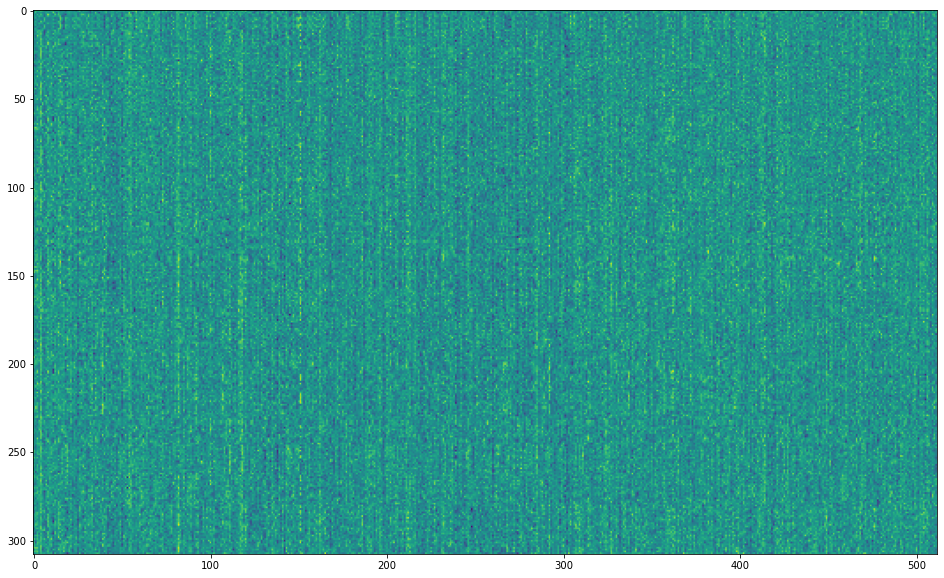

In [22]:
%%time
import numpy as np
embeddings = np.array(embeddings_l)
print(embeddings.shape, embeddings.max(), embeddings.min())

plt.figure(figsize=(20,10))
plt.imshow(embeddings)


## pair-wise distances of Embeddings, removing duplicates

(308, 308)
distance_matrix mean 0.88642687
distance_matrix max 1.2067984
distance_matrix std 0.1385432


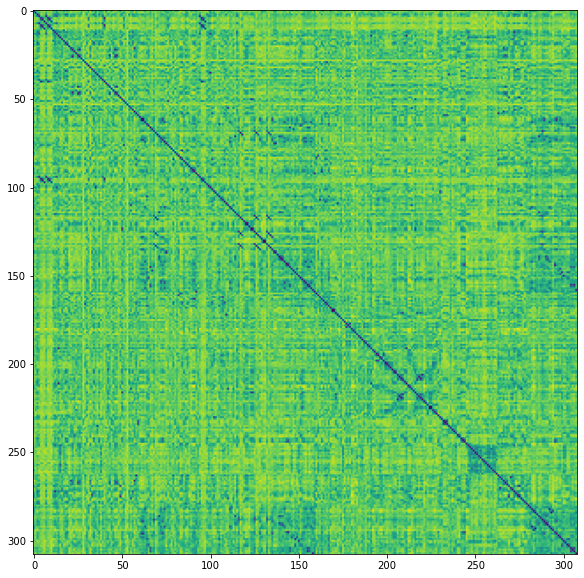

In [23]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

distance_matrix = pairwise_distances(embeddings, embeddings, metric='cosine', n_jobs=1)
print(distance_matrix.shape)
# distance_matrix

plt.figure(figsize=(10,10))
plt.imshow(distance_matrix)
print('distance_matrix mean', distance_matrix.mean())
print('distance_matrix max', distance_matrix.max())
print('distance_matrix std', distance_matrix.std())

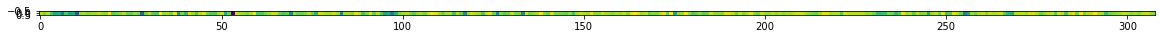

In [24]:
nonsense_distance_matrix = pairwise_distances(embeddings, [center_of_nonsense], metric='cosine', n_jobs=1)
plt.figure(figsize=(20,20))
plt.imshow(nonsense_distance_matrix.T)

In [25]:
# len(X)

In [ ]:
_excluded = set()
_kept = set()

_b=0.7
nonsense_thr = nonsense_distance_matrix.mean() * _b + nonsense_distance_matrix.min() * (1-_b)
print('nonsense_thr', nonsense_thr)

display(Markdown(f'### Бессмысленные паттерны или почти {len(nonsense_distance_matrix)} of {len(strings)}: \
        distance < {nonsense_thr:.2} (min={nonsense_distance_matrix.min():.2}; mean={nonsense_distance_matrix.mean():.2})'))
for i, nd in enumerate(nonsense_distance_matrix):
    d = nd[0]
    if d < nonsense_thr:
        ## trop proche de l'absurde
        print('---')
        _excluded.add(i)
        print(i, d, '\t',strings[i])

In [27]:
np.percentile(distance_matrix, 0.5)

0.11357772350311279

In [ ]:
simlarity_threshold = np.percentile(distance_matrix, 0.5)
display(Markdown(f'### Одинаковые: расстояние < {simlarity_threshold:.2}'))
for i in range(distance_matrix.shape[0]):
    for j in range(i+1, distance_matrix.shape[0]):
        
        d = distance_matrix[i,j]
        
        if d < simlarity_threshold:
            print(i,'vs', j, ', cosine distance =', d)
            _kept.add(i)
            _excluded.add(j)
            

            print(i, strings[i])
            print('='*10)
            print(j, strings[j])
            print('-'*100)
       
# _excluded
display(Markdown(f'#### {len(_excluded)} одинаковых пар'))
print(_kept - _excluded)
print(_excluded)

In [29]:
# for i in range(distance_matrix.shape[0]):
#     if len(strings[i]) < 15:
#         print(strings[i])
#     if len(strings[i]) > 400 :
#         print('-'*100)
#         print(strings[i])
        
#         _excluded.add(i)

In [30]:
import numpy as np
embeddings_filtered = np.delete(embeddings, list(_excluded), axis=0)
strings_filtered = np.delete(strings, list(_excluded), axis=0)
print(embeddings_filtered.shape)

display(Markdown(f'### {embeddings_filtered.shape[0]} -- Количество паттернов после удаления одинаковых'))


del embeddings
del strings

strings = strings_filtered
embeddings = embeddings_filtered

(232, 512)


### 232 -- Количество паттернов после удаления одинаковых

In [31]:
# import pandas as pd
 
# for
# df_describe = pd.DataFrame(distance_matrix)
# print("distance_matrix mean=", distance_matrix.mean())
# print("distance_matrix std=", distance_matrix.std())
# df_describe.describe()


#collect all elements except diagonal zeros
#XXX: mighe be done with smatr sliceing, but im too lazy


def estimate_distance_threshold(patterns_embeddings):
    distance_matrix = pairwise_distances(patterns_embeddings, patterns_embeddings, metric='cosine', n_jobs=1)
    
    dshape = distance_matrix.shape
    distance_matrix_meaningful=[]
    for i in range(dshape[0]):
        for j in range(i):
            distance_matrix_meaningful.append(distance_matrix[i][j])
    distance_matrix_meaningful=np.array(distance_matrix_meaningful)
    len(distance_matrix_meaningful)            

    print("distance_matrix mean=", distance_matrix_meaningful.mean())
    print("distance_matrix max=", distance_matrix_meaningful.max())
    print("distance_matrix std=", distance_matrix_meaningful.std())

    #mean distance plus/minus tandart deviation .. estimating the max distance from clusters...
    threshold = distance_matrix_meaningful.mean() - distance_matrix_meaningful.std() 
    return threshold
    
estimate_distance_threshold(embeddings_filtered)

distance_matrix mean= 0.8850735
distance_matrix max= 1.2067984
distance_matrix std= 0.12157734


0.76349616

## Clustering, t-SNE  3D

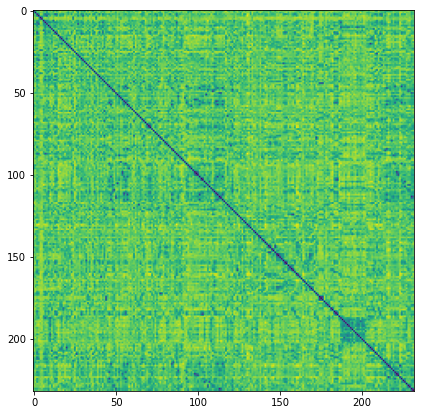

In [32]:

distance_matrix = pairwise_distances(embeddings_filtered, embeddings_filtered, metric='cosine', n_jobs=1)
 
            
plt.figure(figsize=(7,7))
plt.imshow(distance_matrix)

In [33]:
# print(insides.value.unique())????
n_clusters = embeddings_filtered.shape[0] // 10 #len(insides.value.unique())
print('n_clusters', n_clusters)

n_clusters 23


## Clustering, t-SNE  2D

In [34]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=6000, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 232 samples in 0.000s...
[t-SNE] Computed neighbors for 232 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 232 / 232
[t-SNE] Mean sigma: 0.307244


/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.017452
[t-SNE] KL divergence after 1100 iterations: 0.675924


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

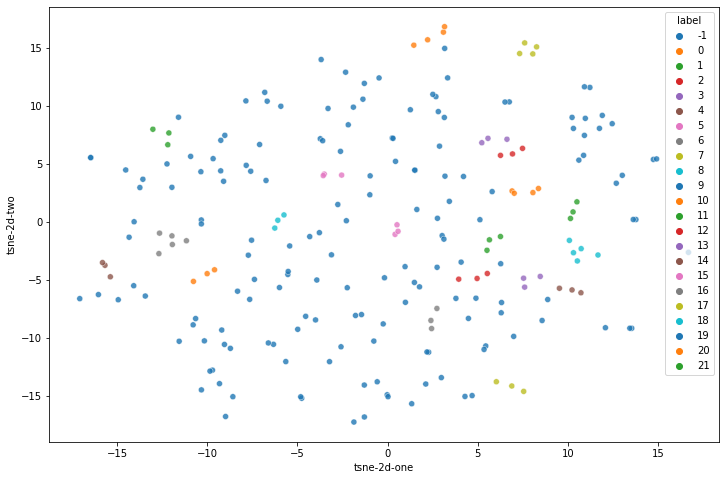

In [35]:
# from sklearn.cluster import SpectralClustering

# kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(np.array(tsne_results))
kmeans = DBSCAN(eps=1.1, min_samples=3 ).fit(tsne_results)
# kmeans = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(tsne_results)

df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = kmeans.labels_


fig=plt.figure(figsize=(12,8) )
# ax = fig.add_subplot(111, projection = '3d')


# ax.scatter(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['tsne-2d-3'])

# plt.show()

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label", palette="tab10",
    data=df_subset,
    alpha=0.8
)



In [36]:
kmeans.__dict__

{'eps': 1.1,
 'min_samples': 3,
 'metric': 'euclidean',
 'metric_params': None,
 'algorithm': 'auto',
 'leaf_size': 30,
 'p': None,
 'n_jobs': None,
 'n_features_in_': 2,
 'core_sample_indices_': array([  4,   7,  13,  14,  20,  24,  26,  36,  43,  44,  46,  47,  50,
         56,  57,  61,  76,  84,  88,  98, 100, 101, 103, 104, 107, 110,
        112, 115, 137, 147, 161, 172, 174, 175, 176, 194, 209, 215, 220,
        224, 226, 230]),
 'labels_': array([-1, -1,  2, -1,  0,  0, -1,  1, -1, -1, -1, -1, -1,  2,  3, -1, -1,
         4, -1, -1,  4, -1,  6, -1,  0, -1,  5, -1, -1,  3, -1, -1, -1, -1,
        -1, -1,  5, -1, -1, -1,  2, -1,  1,  6,  7, -1,  8,  9, -1, -1, 10,
        -1, 11, -1, 12, -1,  8,  9, -1, -1, -1,  6, -1, -1, -1, -1, -1,  6,
        -1, -1, -1, -1, -1, -1, -1, -1,  6, 20, 20, -1, -1, -1, -1, -1,  9,
        -1, -1,  1, 11, -1, -1, -1, -1,  8, -1, -1, -1, -1, 12, 13, 13,  9,
        14, 14, 15, -1, -1, 15, -1, -1, 16, -1,  9, 10, 10,  9, -1, -1, -1,
        -1, -1, -1

In [37]:
# set(kmeans.labels_)

In [38]:
# !conda list

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


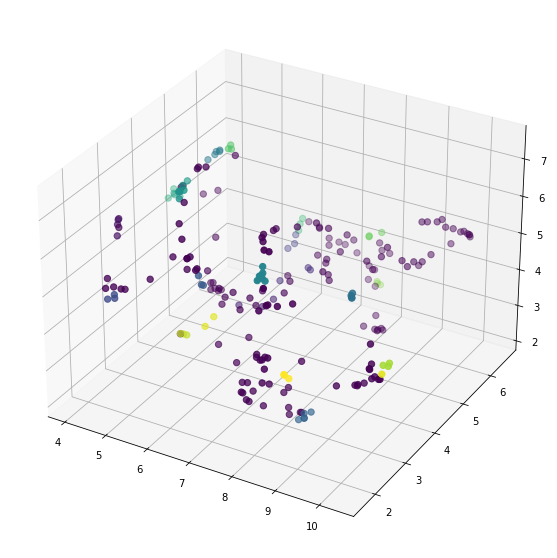

In [39]:
import umap
umap_embeddings = (umap.UMAP(n_neighbors=6, 
                                n_components=3, 
                                metric='cosine', 
                                random_state=42)
                            .fit_transform(embeddings_filtered))


fig=plt.figure(figsize=(10,10) )
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], umap_embeddings[:,2], s=40, c=df_subset['label'] )
 
plt.show()

/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 232 samples in 0.000s...
[t-SNE] Computed neighbors for 232 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 232 / 232
[t-SNE] Mean sigma: 0.299164
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.067474
[t-SNE] KL divergence after 5000 iterations: 2.188469
clusters3d.labels_ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}


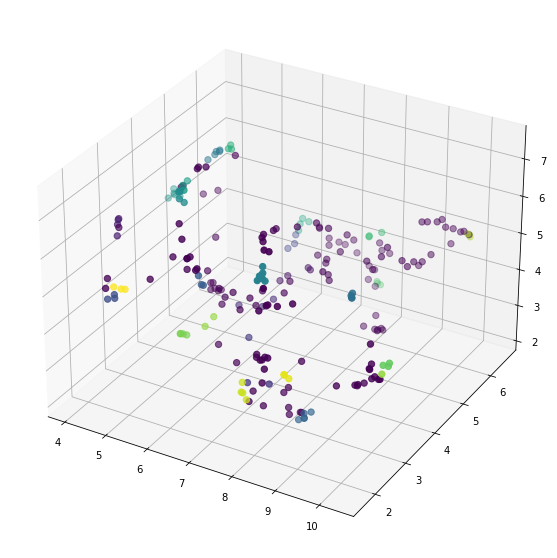

In [40]:
from matplotlib.colors import ListedColormap
 
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())


# from sklearn.cluster import Birch

from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=5000, metric="precomputed")
tsne_results3 = tsne.fit_transform(distance_matrix)




tsne_results3 = umap_embeddings #XXXXXX



# clusters3d = KMeans(n_clusters = n_clusters, random_state=0).fit(np.array(tsne_results))
clusters3d = DBSCAN(eps=1.2, min_samples=3).fit(tsne_results)

print('clusters3d.labels_',set(clusters3d.labels_))
df_subset={}
df_subset['tsne-2d-one'] = tsne_results3[:,0]
df_subset['tsne-2d-two'] = tsne_results3[:,1]
df_subset['tsne-2d-3'] = tsne_results3[:,2]
df_subset['label'] = clusters3d.labels_


fig=plt.figure(figsize=(10,10) )
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['tsne-2d-3'], s=40, c=df_subset['label'] )
 
plt.show()



In [41]:
insides.to_csv('insides.csv', index=True)

In [42]:
# print(len(pca_result))

In [43]:
from colab_support.renderer import HtmlRenderer
import matplotlib as matplotlib
from IPython.core.display import display, HTML

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()

# if SELF_TEST:
#     renderer_.render_color_text(["слово 1", "слово 2"], np.array( [1, 0]), _range=(0,1))

## Finding cluster centers (in embedding space)

In [44]:
lens = [ len (s) for s in strings]
print(lens)

__mean_len = int(np.mean(lens) * 1.75)
print(__mean_len)

[64, 284, 166, 187, 89, 83, 90, 115, 310, 127, 57, 132, 51, 54, 153, 173, 81, 177, 482, 151, 344, 369, 258, 160, 71, 208, 86, 218, 70, 175, 130, 220, 422, 46, 111, 88, 59, 413, 318, 135, 104, 147, 46, 451, 74, 51, 124, 103, 196, 141, 322, 226, 159, 56, 172, 406, 275, 111, 107, 71, 130, 335, 44, 109, 92, 88, 221, 410, 217, 50, 82, 83, 165, 104, 270, 65, 214, 244, 191, 209, 255, 164, 69, 118, 100, 130, 247, 273, 248, 450, 295, 108, 130, 208, 74, 105, 112, 81, 179, 185, 150, 146, 192, 330, 75, 223, 377, 118, 86, 109, 161, 175, 154, 196, 365, 169, 174, 127, 72, 134, 76, 97, 150, 220, 152, 484, 295, 71, 290, 96, 31, 92, 97, 50, 238, 218, 137, 173, 211, 339, 238, 466, 64, 223, 143, 393, 498, 216, 545, 526, 309, 432, 609, 114, 108, 183, 133, 246, 215, 282, 399, 356, 129, 266, 44, 130, 319, 263, 362, 507, 317, 136, 435, 37, 30, 30, 41, 208, 37, 92, 180, 127, 293, 266, 360, 204, 560, 118, 80, 65, 111, 48, 45, 139, 99, 68, 40, 67, 74, 69, 60, 39, 70, 373, 546, 435, 306, 808, 217, 137, 327, 385, 

In [45]:
# kmeans.__dict__

In [46]:
# centroid = np.mean(embeddings_filtered, axis=0)
# del centroid
centroids = []
# print(centroid)


kmeans = clusters3d
# for g in set(kmeans.labels_):
#     group=[]
#     for i in range(len(embeddings_filtered)):
#         if g == kmeans.labels_[i]:
#             if g==-1:
#                 print(k, strings[i],'\n')
#             group.append(embeddings_filtered[i])
# #             print(k, strings[i])
# #             print('-'*100)
#     print(len(group), g)
#     print('='*100)
#     c = np.mean(group, axis=0)
#     centroids.append(c)
#     print( c )

In [ ]:
centroids = []
for k in range(n_clusters):
    group=[]
    for i in range(len(embeddings_filtered)):
        if k == kmeans.labels_[i]:
#             print (k)
            group.append(embeddings_filtered[i])
            print(f'label={k}({i}) \t [{strings[i]}]')
            print('-'*20)
            
    print(f'\n {k} len={len(group)}' )
    print('='*100)
    print(f'\n\n ' )
    
    if len(group)>0:
        centroid = np.mean(group, axis=0)
#         print(centroid)
        centroids.append(centroid)
    else:
        print(f'ACHTUNG group {k} is empty')


In [48]:
# centroids
n_clusters = len(centroids)
n_clusters

23

# Save patterns  (embeddings binary array)

In [49]:
np.save(Path(models_path) / "insides_patterns.npy",  centroids)

# Analysing sample doc

In [50]:
if SELF_TEST:    
    centroids = np.load(Path(models_path) / "insides_patterns.npy")
    print(centroids.shape)
    
distance_threshold = estimate_distance_threshold(centroids)
print('distance_threshold', distance_threshold)

(23, 512)
distance_matrix mean= 0.82497156
distance_matrix max= 1.0445358
distance_matrix std= 0.13878897
distance_threshold 0.6861826


In [53]:
%%time
from bson import ObjectId
if SELF_TEST:
    from analyser.legal_docs import tokenize_doc_into_sentences_map

    sample_id     = ObjectId('617146dd8fd5658689eb2bb4')  #res_inside[0]["_id"] #ObjectId('6166989787f1d9065bb8b914') #
    sample_db_doc = get_doc_by_id(sample_id)
    print('doc has been fetched from mongo')
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()
    
    print(sample_id)



    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), 
                                                              HyperParameters.mean_sentense_pattern_len)
    #TODO: might be employ 3rd party lib
    print(sample_doc)

    doc_embeddings = embedd_strings(sample_doc.sentence_map.tokens)

doc has been fetched from mongo
617146dd8fd5658689eb2bb4
CPU times: user 19.6 s, sys: 1.5 s, total: 21.1 s
Wall time: 2.93 s


In [54]:
len(sample_doc)

1249

In [55]:
mean_len

300

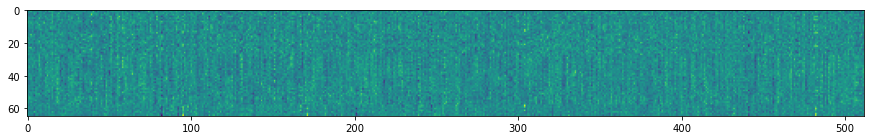

In [56]:
plt.figure(figsize=(15,15))
plt.imshow(doc_embeddings)

65
-0.18113017
(23, 65)
1055


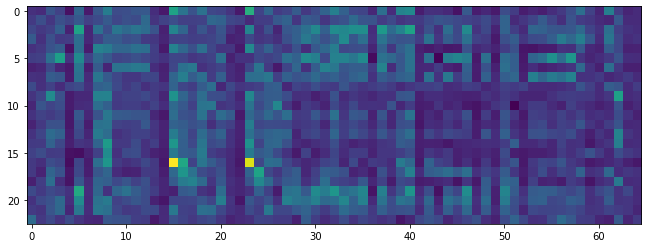

In [57]:
distance_matrix = pairwise_distances(centroids, doc_embeddings , metric='cosine', n_jobs=1)
distance_matrix = (distance_matrix * -1) + 1.0
 
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))
 
print( distance_matrix.min())
print( distance_matrix.shape)
print( distance_matrix.argmax())

In [58]:
def relu(x: np.ndarray, relu_th: float = 0.0) -> np.ndarray:
  _relu = x * (x > relu_th)
  return _relu


distance_threshold 0.6861826

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
16=cluster 	 0.8552128076553345=similarity, 
  Подготовка и передача кредиторам Компании документов (расшифровок к бухгалтерской отчетности, справок из подразделения ФНС России о состоянии расчетов с бюджетом или акт сверки расчетов с бюджетом, 
(269, 298)
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
0.8552128 16


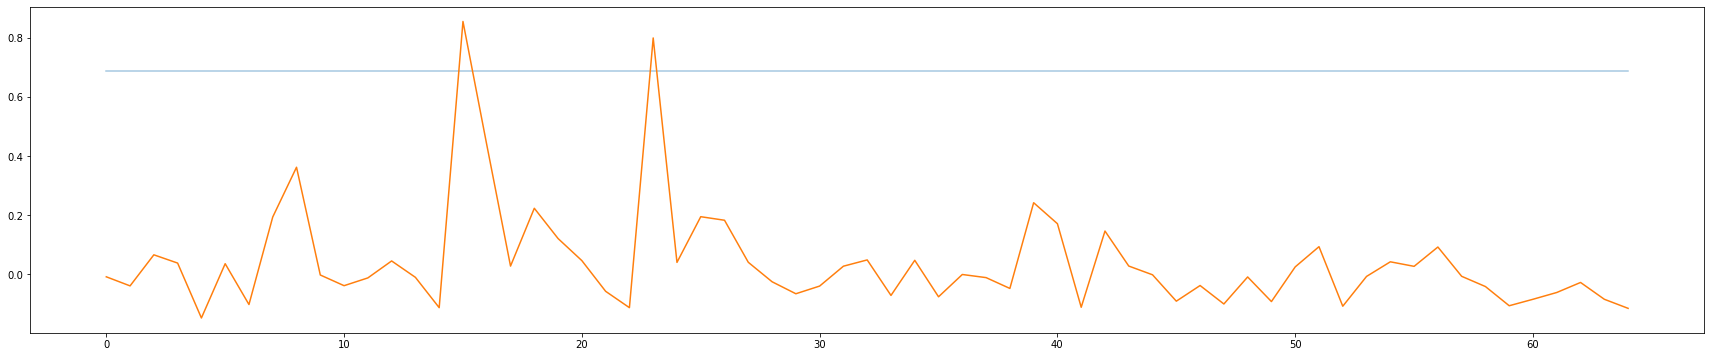

In [63]:
eps = 0.01
# del threshold # = 0.7 #0.9 *  distance_matrix.max()
print('distance_threshold', distance_threshold)
print()
sim_max = 0
# i_max = 0

plt.figure(figsize=(30,6))
plt.plot([distance_threshold]*len(sample_doc.sentence_map), alpha=0.4 )
i_max = 0
for k in range(n_clusters):    
    print('-'*20)
    av = distance_matrix[k] 
    
    ii = av.argmax()
    sim = av[ii]
    if (sim > distance_threshold):
        plt.plot(av)
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
        _span = sample_doc.sentence_map.remap_span((ii, ii + 1), sample_doc.tokens_map)
        print(_span)
    
    if sim > sim_max:
        i_max = k
        sim_max = sim
        
print(sim_max, i_max)

In [ ]:
relu_threshold =  0.85 *  distance_matrix.max()
renderer_.render_color_text(sample_doc.sentence_map.tokens, relu(distance_matrix[i_max], relu_threshold), _range=(0,1), separator='<br>')

## Test no-insides DOC

In [65]:
%%time
from bson import ObjectId

# doc =

if SELF_TEST:
    sample_db_doc    =  get_doc_by_id(ObjectId('60dec1f556214d9842813fcb'))    
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()
    
    
    print(sample_doc)
    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), mean_len)

#     print(sample_doc)

    doc_embeddings = embedd_strings(sample_doc.sentence_map.tokens)

/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


CPU times: user 14 s, sys: 1.07 s, total: 15 s
Wall time: 2.31 s


66


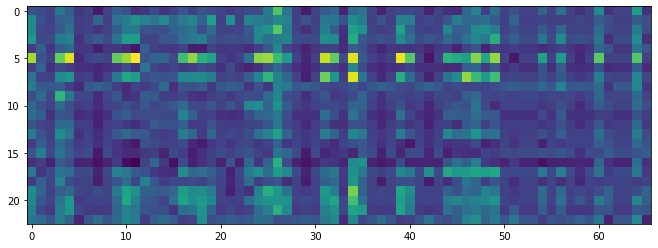

In [66]:
X = doc_embeddings
distance_matrix = pairwise_distances(X, centroids, metric='cosine', n_jobs=1)
# distance_matrix = relu ( ((distance_matrix * -1)+1) , _mx-0.01)

distance_matrix = (distance_matrix * -1)+1.0
distance_matrix = distance_matrix.T
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))

threshold 0.85

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
0.48492712 5


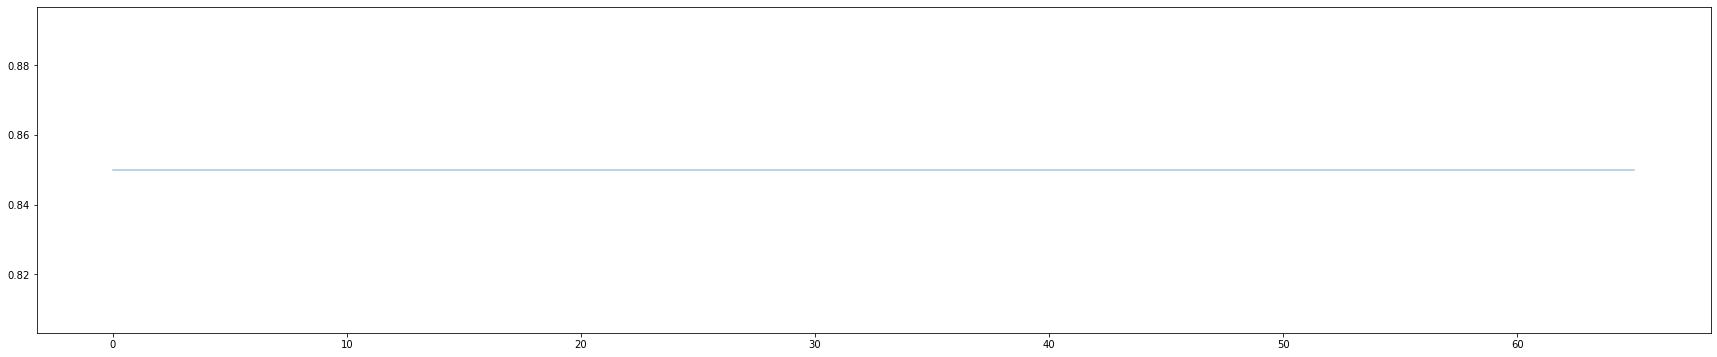

In [67]:
eps = 0.01
threshold = 0.85 #0.9 *  distance_matrix.max()
print('threshold', threshold)
print()
sim_max=0
i_max=0
plt.figure(figsize=(30,6))
plt.plot([threshold]*len(sample_doc.sentence_map), alpha=0.4 )
for k in range(n_clusters):    
    print('-'*20)
    v = distance_matrix[k] 
    av = v #relu(v, threshold) ## attention vector
    
    ii = av.argmax()
    sim = av[ii]
    if (sim > threshold):
        plt.plot(av)
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
    
    if sim>sim_max:
        i_max = k
        sim_max = sim
print(sim_max, i_max)

In [ ]:
relu_threshold =  0.99 *  distance_matrix.max()
renderer_.render_color_text(sample_doc.sentence_map.tokens, distance_matrix[i_max])